# Train the autoencoder

Autoencoder is for reducing the dimension of the input images by converting into latent space.
Here we will train an autoencoder which input image is of 112x112 pixels and the laten space will be 3x28x28.
This model will be used for traing the diffusion models in next notebook


In [1]:
##Import libraries

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import cv2
import glob
from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()
torch.cuda.empty_cache()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/default/miniconda3/envs/monai_generative_ai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.22.0
Pillow version: 10.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about instal

In [2]:
set_determinism(42)

## Creating custom dataset for reading images

In [4]:
class CustomDataset(Dataset):
  def __init__(self,path):
    self.imgs_path = path
    file_list = glob.glob(self.imgs_path+ "*")

    self.data=[]
    for class_path in file_list:
      class_name = class_path.split("/")[-1]
      for img_path in glob.glob(class_path+"/*"):
        self.data.append([img_path,1 if class_name=="0" or class_name =="1" else 2])

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    img_path,class_id = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img,(112,112)) # resizing here
    gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_image.resize(112,112,1)
    img_tensor = torch.from_numpy(gray_image*1.0)
    img_tensor = img_tensor.permute(2,0,1)
    class_id = torch.tensor([class_id])
    img_tensor /= 255.
    return img_tensor , class_id

In [5]:
## Define the custom dataset
training_dataset = CustomDataset('/home/default/monai_generative_ai/Knee_Osteoarthritis/train/')
validation_dataset = CustomDataset('/home/default/monai_generative_ai/Knee_Osteoarthritis/val/')

In [8]:
len(training_dataset)

5778

## Printing an training image 

tensor([1])


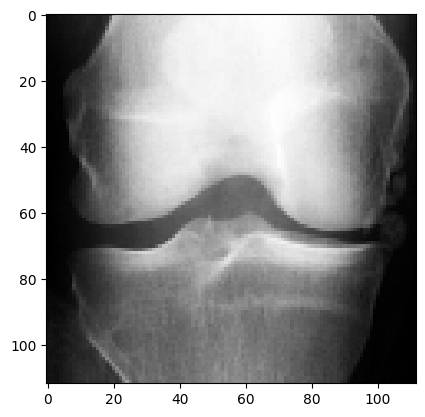

In [11]:
data_loader = DataLoader(training_dataset,batch_size=4,shuffle=True)
for img,label in data_loader:
  break
image =img[0]
print(label[0])
plt.imshow(image.permute(1,2,0),cmap="gray")
plt.show()

## Define Autoencoder 

In [6]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [13]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/home/default/miniconda3/envs/monai_generative_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/default/miniconda3/envs/monai_generative_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [15]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

In [7]:
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

## Training

In [17]:
## Train the model
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        # images = batch["image"].to(device)
        images = batch[0].float()
        images = images.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                # images = batch["image"].to(device)

                images = batch[0].float()
                images = images.to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 9: 100%|███████████████████| 91/91 [00:31<00:00,  2.85it/s, recons_loss=0.0202, gen_loss=0, disc_loss=0]


epoch 10 val loss: 0.0195


Epoch 19: 100%|██████████| 91/91 [00:33<00:00,  2.68it/s, recons_loss=0.0182, gen_loss=0.268, disc_loss=0.258]


epoch 20 val loss: 0.0189


Epoch 29: 100%|██████████| 91/91 [00:34<00:00,  2.68it/s, recons_loss=0.0146, gen_loss=0.284, disc_loss=0.252]


epoch 30 val loss: 0.0156


Epoch 39: 100%|███████████| 91/91 [00:33<00:00,  2.68it/s, recons_loss=0.013, gen_loss=0.291, disc_loss=0.247]


epoch 40 val loss: 0.0139


Epoch 49: 100%|██████████| 91/91 [00:33<00:00,  2.68it/s, recons_loss=0.0132, gen_loss=0.268, disc_loss=0.247]


epoch 50 val loss: 0.0122


Epoch 59: 100%|██████████| 91/91 [00:34<00:00,  2.68it/s, recons_loss=0.0126, gen_loss=0.271, disc_loss=0.252]


epoch 60 val loss: 0.0114


Epoch 69: 100%|██████████| 91/91 [00:33<00:00,  2.68it/s, recons_loss=0.0115, gen_loss=0.295, disc_loss=0.253]


epoch 70 val loss: 0.0144


Epoch 79: 100%|██████████| 91/91 [00:33<00:00,  2.68it/s, recons_loss=0.0127, gen_loss=0.316, disc_loss=0.231]


epoch 80 val loss: 0.0143


Epoch 89: 100%|███████████| 91/91 [00:34<00:00,  2.68it/s, recons_loss=0.0115, gen_loss=0.31, disc_loss=0.242]


epoch 90 val loss: 0.0118


Epoch 99: 100%|██████████| 91/91 [00:33<00:00,  2.68it/s, recons_loss=0.0115, gen_loss=0.296, disc_loss=0.249]


epoch 100 val loss: 0.0111


## Save the model

In [8]:
PATH = '/home/default/monai_generative_ai/auto_encoder_model.pt'

In [4]:
## Save the model , uncomment the following for saving the model in the above PATH

# torch.save(autoencoderkl.state_dict(), PATH)

## Load the model

In [9]:
autoencoderkl.load_state_dict(torch.load(PATH))
autoencoderkl.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): Downsample(
        (conv): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4-5): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(3

## Take a sample and perform reconstruction

In [10]:
with torch.no_grad():
    autoencoderkl.eval()
    for val_step, batch in enumerate(train_loader, start=1):

        images = batch[0].float()
        images = images.to(device)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)
        break

In [13]:
image = images[0].to("cpu")
re_img = reconstruction[0].to("cpu")

## Original Image

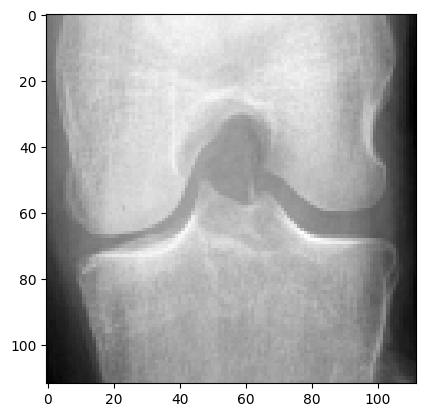

In [14]:
plt.imshow(image.permute(1,2,0),cmap="gray")
plt.show()

## Reconstructed image

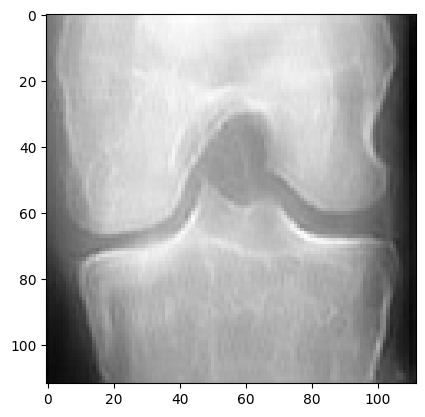

In [15]:
plt.imshow(re_img.permute(1,2,0),cmap="gray")
plt.show()

In [18]:
with torch.no_grad():
    autoencoderkl.eval()
    for val_step, batch in enumerate(train_loader, start=1):

        images = batch[0].float()
        images = images.to(device)

        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            # reconstruction, z_mu, z_sigma = autoencoderkl(images)

        
        break

In [ ]:
z.shape